Import relevant libraries

In [1]:
import pandas as pd
from Preprocessing.preprocessing import preprocessing
import time
import torch
from tsai.all import *
import os
from Optimizer.optimizer import optimize_model, optimize_data_classification, optimize_data_regression
from Evaluation.evaluation_tsai import calculate_pseudo_return, get_plots_classification, get_plots_regression
from fastai.callback.tracker import EarlyStoppingCallback

print('GPU support:', torch.cuda.is_available())
computer_setup()

c:\Users\karll\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU support: False
os              : Windows-10-10.0.22621-SP0
python          : 3.9.13
tsai            : 0.3.5
fastai          : 2.7.11
fastcore        : 1.5.28
torch           : 1.13.1+cpu
cpu cores       : 6
threads per cpu : 2
RAM             : 15.9 GB
GPU memory      : [6.0] GB


In [2]:
from Optimizer.optimizer import optimize_model

df = pd.read_csv('Data\Stock\StockBars\MSFT_Minute')
 
preprocessing_params = {
    'df': df[:1000],
    'lag': 1,
    'dif_all': True,
    'train_size': 0.8,
    'TSAI': True,
    'CLF': True,
    'index': None,
    'data': "alpacca",
    'buckets': 1
}

model_type = 'tst_class'

opti = False
if opti:
    optimize_model(model_type=model_type, preprocessing_params=preprocessing_params, n_trials=1, n_epochs=2)

results_df = pd.read_csv(f"models/{model_type}/{model_type}_hyperparameters_results.csv")
results_df

,model,seq_length,d_model,n_layers,n_heads,d_ff,dropout,learning_rate,val_accuracy,time
0,tst_class,150,64,4,8,512,0.3,0.008840,0.485714,0.007979
1,tst_class,300,512,2,8,128,0.0,0.000022,0.485714,0.025931
2,tst_class,100,64,1,32,256,0.3,0.001682,0.474286,0.002990
3,tst_class,50,256,2,32,128,0.3,0.005856,0.462857,0.008975
4,tst_class,150,512,2,32,1024,0.0,0.009368,0.488235,0.058642


In [2]:
from Optimizer.optimizer import optimize_data_classification, optimize_data_regression

model = "lstm"
df = pd.read_csv('Data\\twelve_data\AAPL_1min')
timestep = '1min'
epochs = 10
trials = 80


#preprocessing(df[:1000],data='twelve',index = '1min')

optimize_data_classification()


[I 2023-03-23 13:52:07,490] A new study created in memory with name: no-name-814ec68a-9c07-4615-b132-24e6b3b5388f


after null10000
9998
9998


[I 2023-03-23 13:52:11,636] Trial 0 finished with value: 0.48848848848848847 and parameters: {'buckets': 10, 'dif_all': False, 'TI': False, 'index': '1min', 'batch_size': 128}. Best is trial 0 with value: 0.48848848848848847.


after null10000
9998
9998


[I 2023-03-23 13:52:23,406] Trial 1 finished with value: 0.4914914914914915 and parameters: {'buckets': 8, 'dif_all': False, 'TI': False, 'index': None, 'batch_size': 16}. Best is trial 1 with value: 0.4914914914914915.


after null10000
9998
9998


[I 2023-03-23 13:52:37,329] Trial 2 finished with value: 0.5385385385385385 and parameters: {'buckets': 8, 'dif_all': True, 'TI': False, 'index': None, 'batch_size': 16}. Best is trial 2 with value: 0.5385385385385385.


after null10000
9998
9998


[I 2023-03-23 13:52:43,430] Trial 3 finished with value: 0.5075075075075075 and parameters: {'buckets': 11, 'dif_all': False, 'TI': False, 'index': None, 'batch_size': 64}. Best is trial 2 with value: 0.5385385385385385.


after null9977
9975
9975


[I 2023-03-23 13:52:49,579] Trial 4 finished with value: 0.4974924774322969 and parameters: {'buckets': 15, 'dif_all': True, 'TI': True, 'index': None, 'batch_size': 64}. Best is trial 2 with value: 0.5385385385385385.


In [ ]:
model_type = 'tst_class'

with open(f"models/{model_type}/{model_type}_best_params.json", "r") as f:
    best_params = json.load(f)

best_params

{'seq_length': 150,
 'batch_size': 128,
 'learning_rate': 0.009367651744319094,
 'd_model': 512,
 'n_layers': 2,
 'n_heads': 32,
 'd_ff': 1024,
 'dropout': 0.0}

Select a stock for Machine Learning Model Training and preprocesses it

In [ ]:
# Preprocess the data using a custom function and split it into training and testing sets
# Only the training and testing sets are used, so the third variable (a scalar) is discarded using an underscore

seq_length = best_params.pop('seq_length', None)
data_train, data_test, _ = preprocessing(**preprocessing_params, sequence_length=seq_length, print_info=True)

# Changes the data into features and labels with the split used later in TSAI for modelling
X, y, splits = combine_split_data([data_train[0], data_test[0]],[data_train[1], data_test[1]])

# Utilizes the GPU if possible
if torch.cuda.is_available(): X, y = X.cuda(), y.cuda()

batch_size = best_params.pop('batch_size', None)
dsets = TSDatasets(X, y, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=batch_size)

# Note this tabel is before sequenceing so the actuall values is total - sequence then times train_size

   Label  Count  Train count  Test count  Bucket min  Bucket max
0    0.0    432          338          93     -1.0488     -0.0001
1    1.0    566          460         106      0.0000      0.9588
2  Total    998          798         199     -1.0488      0.9588


Initializes the models and learners

In [ ]:
nr_features = X.shape[1] # Number of features
nr_labels = torch.unique(y).numel() # Number of labels

model_params = {key: value for key, value in best_params.items() if key not in ('seq_length', 'batch_size', 'learning_rate')}

# Initiates the models
if model_type == 'lstm_class': model = LSTMPlus(c_in=nr_features, c_out=nr_labels, seq_len=seq_length)
if model_type == 'lstm_fcn_class': model = LSTM_FCNPlus(c_in=nr_features, c_out=nr_labels, **model_params, shuffle=False)
if model_type == 'tst_class': model = TST(c_in=nr_features, c_out=nr_labels, seq_len=seq_length)

# Create Learner objects
binary_classification_metrics = [accuracy]

# Initiates a learner
learner = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=accuracy, cbs=[EarlyStoppingCallback(patience=5)])

# Trains the model
epochs = 100
learner.fit_one_cycle(n_epoch = epochs)

if torch.cuda.is_available(): X, y = X.cpu(), y.cpu()

# Save the model
if model_type == 'lstm_class': model_name = "trained_lstm"
if model_type == 'lstm_fcn_class': model_name = "trained_lstm_fcn"
if model_type == 'tst_class': model_name = "trained_tst"

learner.save(model_name)

#calculate_pseudo_return(lag = preprocessing_params.pop('lag', None), sequence_length = seq_length, splits = splits, df = df, predictions, transaction_cost = 0)
get_plots_classification(learner, X, y, splits, 1)

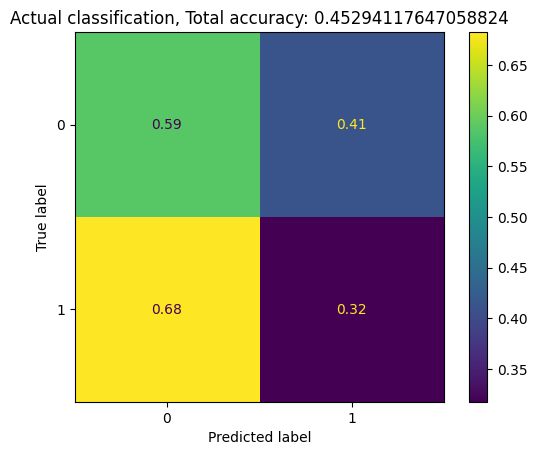

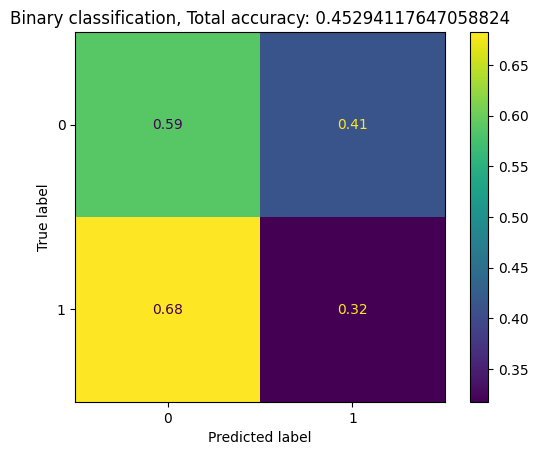

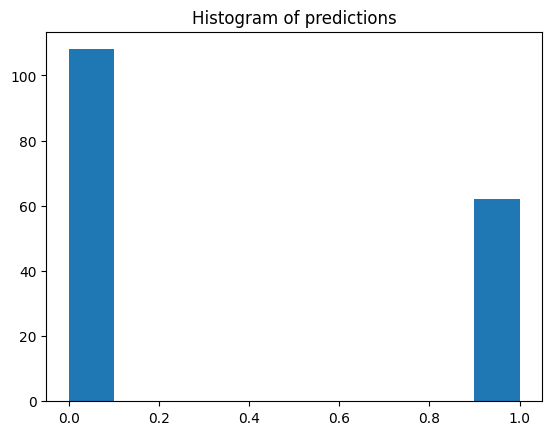

In [ ]:
#Add plots automatically
from Evaluation.evaluation_tsai import calculate_pseudo_return, get_plots_classification

get_plots_classification(learners['TST'], X, y, splits, 1)
calculate_pseudo_return